In [1]:
# Using rasterio packages

In [18]:
import xshape
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
import pandas as pd
from netCDF4 import Dataset
import pickle
import time

In [3]:
# Load data from shapefile using xshape (which uses xarray)
sf_dir = 'World_EEZ_v10_20180221_HR_0_360/'
fields, polygons = xshape.parse_shapefile(
    sf_dir + 'World_EEZ_v10_2018_0_360',
    encoding='latin1')

In [4]:
fields

<xarray.Dataset>
Dimensions:     (shape: 283)
Coordinates:
  * shape       (shape) int64 0 1 2 3 4 5 6 7 ... 276 277 278 279 280 281 282
Data variables:
    cat         (shape) <U90 '45' '229' '253' '2' ... '249' '97' '57' '267'
    MRGID       (shape) <U90 '8323.0' '26526.0' '48957.0' ... '8339.0' '48975.0'
    GeoName     (shape) <U90 'Australian Exclusive Economic Zone' ... 'Joint regime area Iceland / Norway (Jan Mayen)'
    MRGID_Ter1  (shape) <U90 '2147.0' '26525.0' '8599.0' ... '8610.0' '2129.0'
    Pol_type    (shape) <U90 '200NM' '200NM' '200NM' ... '200NM' 'Joint regime'
    MRGID_Sov1  (shape) <U90 '2147.0' '15.0' '2204.0' ... '17.0' '2129.0'
    Territory1  (shape) <U90 'Australia' 'Sint-Eustatius' ... 'Iceland'
    ISO_Ter1    (shape) <U90 'AUS' 'BES' 'GUM' 'NLD' ... 'PSE' 'BRA' 'ATF' 'ISL'
    Sovereign1  (shape) <U90 'Australia' 'Netherlands' ... 'France' 'Iceland'
    MRGID_Ter2  (shape) <U90 '0.0' '0.0' '0.0' '0.0' ... '0.0' '0.0' '5343.0'
    MRGID_Sov2  (shape) <U90 

In [6]:
# Store MRGID, cat, ISO country codes and full name in dataframe
field_MRGID = fields['MRGID'].data.astype(float).astype(int)
field_cat = fields['cat'].data.astype(float).astype(int)
field_iso = fields['ISO_Ter1'].data
field_GeoName = fields['GeoName'].data
EEZ_df = pd.DataFrame(zip(field_cat, field_MRGID, field_iso, field_GeoName), columns=['ID','MRGID','ISO','GeoName'])
EEZ_df.set_index('MRGID', inplace=True)
EEZ_df.head()

,ID,ISO,GeoName
MRGID,,,
8323,45,AUS,Australian Exclusive Economic Zone
26526,229,BES,Sint-Eustatius Exclusive Economic Zone
48957,253,GUM,Guam Exclusive Economic Zone
5668,2,NLD,Dutch Exclusive Economic Zone
8394,110,COG,Congolese Exclusive Economic Zone


In [7]:
# Tiff file burned by Isolde Glissenaar
eez_tiff = xr.open_rasterio('eez.tiff')

In [8]:
EEZ = np.copy(eez_tiff[0, :, :])
for k, v in EEZ_df.to_dict()['ID'].items(): 
    EEZ[eez_tiff[0, :, :]==k] = v
lats = eez_tiff['y']
lons = eez_tiff['x']

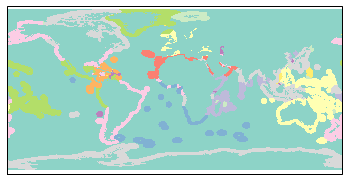

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, EEZ, cmap='Set3')
plt.show()

In [11]:
outfile = open('EEZ_mapping_df.pickle', 'wb')
pickle.dump(EEZ_df, outfile)

In [14]:
ds = Dataset('EEZ_export.nc', 'w', format='NETCDF4_CLASSIC')

In [15]:
nc_dim_lat = ds.createDimension('lat', 1726)
nc_dim_lon = ds.createDimension('lon', 3600)
nc_dim_time = ds.createDimension('time', None)

In [16]:
nc_var_lat = ds.createVariable('latitude', np.float32, ('lat',))
nc_var_lon = ds.createVariable('longitude', np.float32, ('lon',))
nc_var_times = ds.createVariable('time', np.float32, ('time',))
nc_var_EEZ = ds.createVariable('EEZ', np.float32, ('time', 'lat', 'lon'))

In [19]:
# Global attributes
ds.description = "EEZ fields on 0.1 degree grid. Numbers correspond to regions as specified in self-made dictionary"
ds.history = "Created" + time.ctime(time.time())

In [23]:
nc_var_lat.units = 'degree_north'
nc_var_lat.long_name = 'Center latitude'
nc_var_lon.units = 'degree_east'
nc_var_lon.long_name = 'Center longitude'
nc_var_EEZ.long_name = 'Exclusive economic zone - Code number of country  island or area to which EEZ area of this cell belongs for all coastal and oceanic cells'

In [24]:
nc_var_lat[:] = lats
nc_var_lon[:] = lons
nc_var_EEZ[0,:,:] = EEZ

In [25]:
ds.close() #DONE